In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time  # Added to measure runtime

In [2]:
# Load data
images = np.load('../../task_2/data/data_big/images.npy')
labels = np.load('../../task_2/data/data_big/labels.npy')

In [3]:
# Label preparation functions
def prepare_labels_for_classification(labels):
    categories = np.array([label[0] * 60 + label[1] for label in labels])
    return tf.keras.utils.to_categorical(categories, num_classes=720)

In [4]:
def prepare_labels_for_regression_circular(labels):
    hours = labels[:, 0] * (2 * np.pi / 12)
    minutes = labels[:, 1] * (2 * np.pi / 60)
    return np.stack(
        [np.cos(hours), np.sin(hours), np.cos(minutes), np.sin(minutes)],
        axis=-1
    )

In [5]:
def prepare_labels_for_regression_decimal(labels):
    return labels[:, 0] + labels[:, 1] / 60.0

In [6]:
# Data preprocessing
images = images / 255.0
if len(images.shape) == 3:
    images = np.expand_dims(images, axis=-1)

In [7]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [8]:
# Prepare test labels for each model
y_test_classification = prepare_labels_for_classification(y_test)
y_test_regression_circular = prepare_labels_for_regression_circular(y_test)
y_test_regression_decimal = prepare_labels_for_regression_decimal(y_test)

In [9]:
# Model paths
models_paths = [
    '../../task_2/final_models/one_head_720_time_classifier.h5',  # Single-head classification model path
    '../../task_2/final_models/classification_multihead_without_labels_train_model.h5',  # Multi-head classification model path
    '../../task_2/final_models/regression_singelhead_with_labels_train_model.h5',  # Circular regression model path
    '../../task_2/final_models/singlehead_regression_without_labels_trained_model.h5'  # Decimal regression model path
]

In [10]:
# Model types and names for plotting
model_types = [
    'single_classification',
    'multihead_classification',
    'circular_regression',
    'decimal_regression'
]

In [11]:
model_names = [
    'Single-head Classification',
    'Multi-head Classification',
    'Circular Regression',
    'Decimal Regression'
]

In [12]:
# Function to compute minimal time difference considering circularity
def compute_time_difference(pred_times, true_times):
    """
    Compute the minimal absolute difference between predicted and true times,
    considering circularity. Times are in minutes (0 to 720).
    """
    diff = np.abs(pred_times - true_times)
    return np.minimum(diff, 720 - diff)

In [13]:
# Function to convert (hour, minute) to decimal time in minutes
def time_to_minutes(hours, minutes):
    return (hours % 12) * 60 + minutes

In [14]:
# Function to convert outputs to decimal time in minutes
def get_predicted_times(model, X_test, model_type):
    if model_type == 'single_classification':
        preds = model.predict(X_test, verbose=0)
        pred_classes = np.argmax(preds, axis=1)
        pred_times = pred_classes  # Each class corresponds to a unique minute
    elif model_type == 'multihead_classification':
        preds = model.predict(X_test, verbose=0)
        # Since preds is a list, we access outputs using indices
        hour_preds = np.argmax(preds[0], axis=1)
        minute_preds = np.argmax(preds[1], axis=1)
        pred_times = time_to_minutes(hour_preds, minute_preds)
    elif model_type == 'circular_regression':
        preds = model.predict(X_test, verbose=0)
        # preds shape: (num_samples, 4)
        # [cos(hour), sin(hour), cos(minute), sin(minute)]
        # Convert back to angles
        hour_angles = np.arctan2(preds[:, 1], preds[:, 0])  # arctangent of sin/cos
        minute_angles = np.arctan2(preds[:, 3], preds[:, 2])
        # Convert angles to hours and minutes
        hours = ((hour_angles % (2 * np.pi)) * 12 / (2 * np.pi))
        minutes = ((minute_angles % (2 * np.pi)) * 60 / (2 * np.pi))
        pred_times = time_to_minutes(hours, minutes)
    elif model_type == 'decimal_regression':
        preds = model.predict(X_test, verbose=0).flatten()
        pred_times = (preds % 12) * 60  # Convert hours to minutes
    else:
        raise ValueError('Unknown model type')
    return pred_times

In [15]:
# Function to get true times in decimal minutes
def get_true_times(y_test):
    return time_to_minutes(y_test[:, 0], y_test[:, 1])

In [16]:
# Evaluate models, compute MAE, and measure runtime
mae_list = []
runtime_list = []

In [17]:
for model_path, model_type, model_name in zip(models_paths, model_types, model_names):
    print(f"Evaluating {model_name}:")
    model = load_model(model_path, compile=False)

    # Measure runtime
    start_time = time.time()
    # Get predicted times in minutes
    pred_times = get_predicted_times(model, X_test, model_type)
    end_time = time.time()
    runtime = end_time - start_time
    runtime_list.append(runtime)

    # Get true times in minutes
    true_times = get_true_times(y_test)
    # Compute minimal time differences considering circularity
    time_diffs = compute_time_difference(pred_times, true_times)
    # Compute MAE
    mae = np.mean(time_diffs)
    mae_list.append(mae)
    print(f"{model_name} - MAE (minutes): {mae:.2f}, Runtime (seconds): {runtime:.4f}")

Evaluating Single-head Classification:
Single-head Classification - MAE (minutes): 179.36, Runtime (seconds): 2.7000
Evaluating Multi-head Classification:
Multi-head Classification - MAE (minutes): 23.64, Runtime (seconds): 1.6533
Evaluating Circular Regression:
Circular Regression - MAE (minutes): 46.87, Runtime (seconds): 1.5501
Evaluating Decimal Regression:
Decimal Regression - MAE (minutes): 90.38, Runtime (seconds): 1.4532


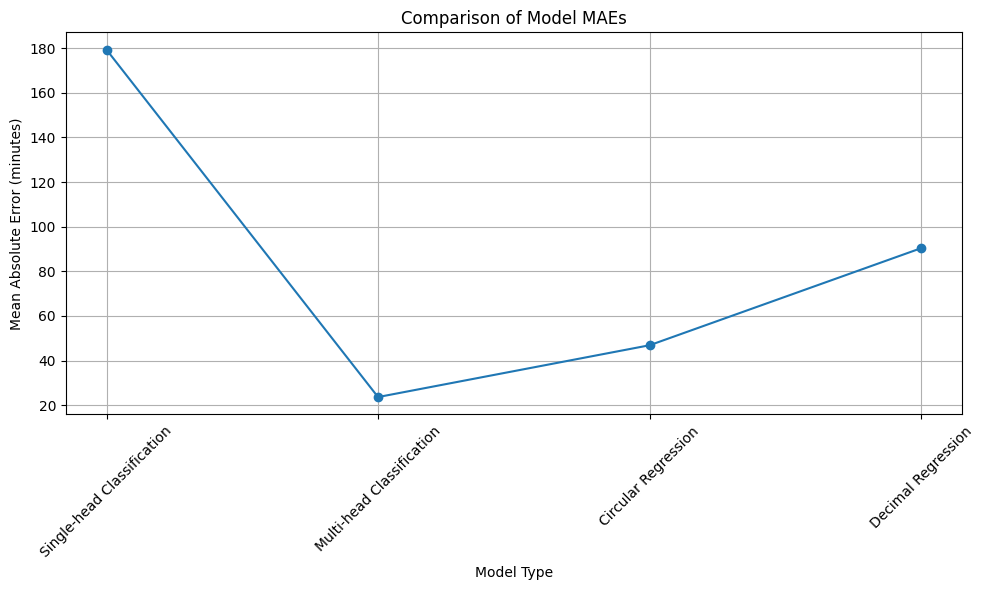

In [18]:
# Plotting MAE for all models
plt.figure(figsize=(10, 6))
plt.plot(model_names, mae_list, marker='o', linestyle='-')
plt.xlabel('Model Type')
plt.ylabel('Mean Absolute Error (minutes)')
plt.title('Comparison of Model MAEs')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

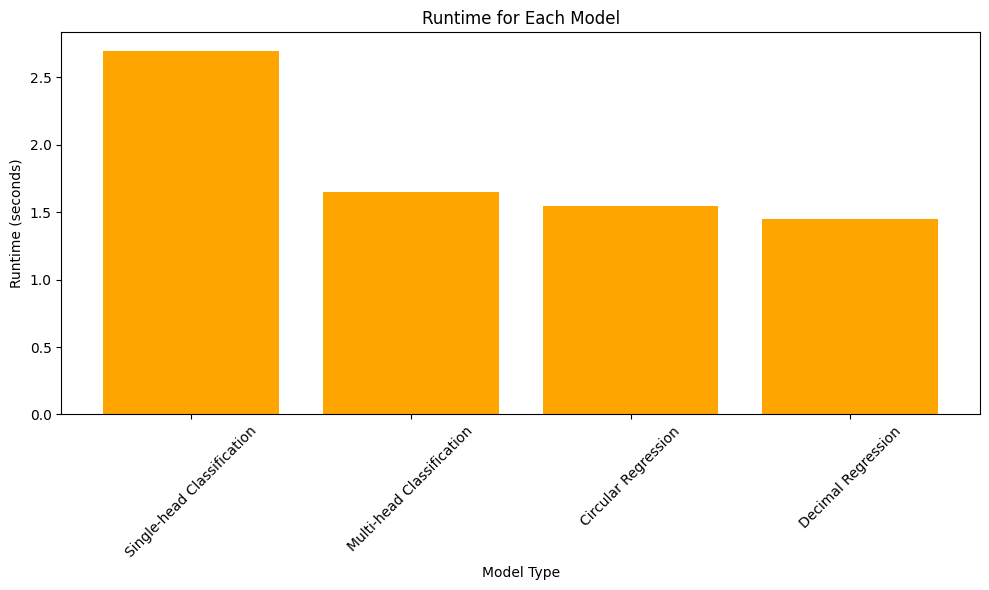

In [19]:
# Plotting Runtime for all models
plt.figure(figsize=(10, 6))
plt.bar(model_names, runtime_list, color='orange')
plt.xlabel('Model Type')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime for Each Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

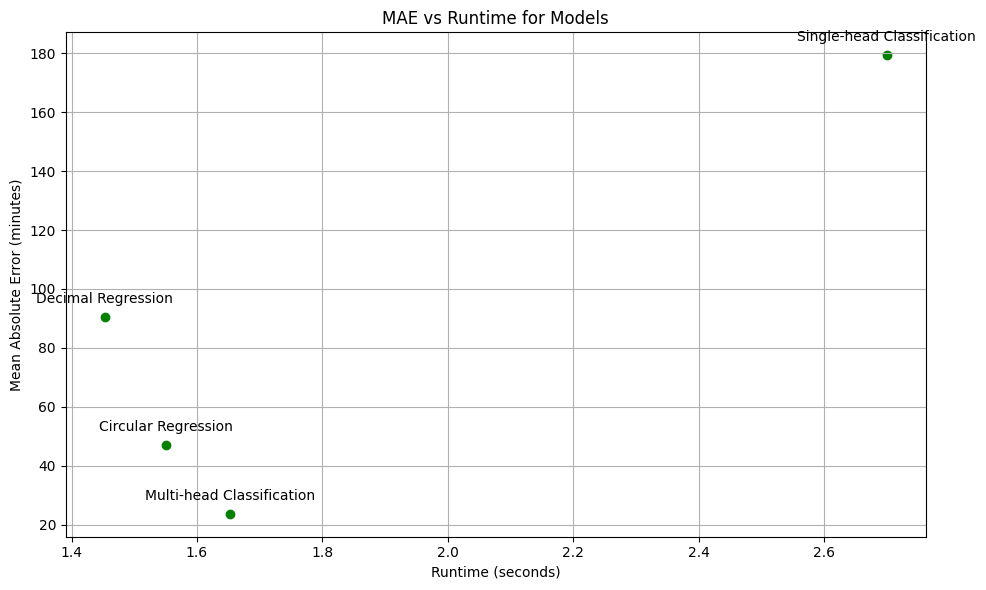

In [20]:
# Plotting MAE vs Runtime
plt.figure(figsize=(10, 6))
plt.scatter(runtime_list, mae_list, color='green')
for i, model_name in enumerate(model_names):
    plt.annotate(
        model_name,
        (runtime_list[i], mae_list[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )
plt.xlabel('Runtime (seconds)')
plt.ylabel('Mean Absolute Error (minutes)')
plt.title('MAE vs Runtime for Models')
plt.grid(True)
plt.tight_layout()
plt.show()